In [168]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

In [169]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers


In [170]:
def Scaler(data):
  # scale the data
  # z-score all columns except for quality
  cols2zscore = data.keys()
  cols2zscore = cols2zscore.drop('quality')
  data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

  return data.copy()

In [171]:
# Function to change the threshold of wine quality

def wineQuality(data, qualityThreshold):

  data = Scaler(data)
  #create a new column for binarized (boolean) quality
  data['boolQuality'] = 0

  quality_thresh = (data['quality']> qualityThreshold).astype(int)
  data['boolQuality'] = quality_thresh

  return data

In [172]:
data = wineQuality(data, qualityThreshold=6)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,0
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0


# Re-organize the data: train/test in DataLoaders

In [173]:
# convert from pandas dataframe to tensor
def convert_to_tensor(data,cols2zscore, qualityThreshold):
  data = wineQuality(data.copy(), qualityThreshold=qualityThreshold)
  dataT  = torch.tensor( data[cols2zscore].values ).float()
  labels = torch.tensor( data['boolQuality'].values ).float()
  labels = labels[:,None] # transform to matrix
  return dataT,labels

dataT, labels = convert_to_tensor(data,cols2zscore=data.keys().drop(['quality','boolQuality']), qualityThreshold=6)

In [174]:
dataT, labels = convert_to_tensor(data,cols2zscore=data.keys().drop(['quality','boolQuality']), qualityThreshold=6)

In [175]:
# use scikitlearn to split the data
def split_data(dataT,labels, thresh):
  dataT,labels = convert_to_tensor(data,cols2zscore=data.keys().drop(['quality','boolQuality']), qualityThreshold=thresh)
  train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

  # then convert them into PyTorch Datasets (note: already converted to tensors)
  train_data = TensorDataset(train_data,train_labels)
  test_data  = TensorDataset(test_data,test_labels)

  # finally, translate into dataloader objects
  batchsize    = 64
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

  return train_loader,test_loader

In [176]:
train_loader,test_loader = split_data(dataT,labels, 6)

# Create ANN model

In [177]:
class ANNmodel(nn.Module):
  def __init__(self):
    super().__init__()

    #input layer
    self.input = nn.Linear(in_features=11,out_features=32)

    #hidden layers
    self.hidden1 = nn.Linear(in_features=32,out_features=32)
    self.hidden2 = nn.Linear(in_features=32,out_features=32)

    #output layer
    self.output = nn.Linear(in_features=32,out_features=1)

  def forward(self,x):
    x = F.leaky_relu(self.input(x))
    x = F.leaky_relu(self.hidden1(x))
    x = F.leaky_relu(self.hidden2(x))
    x = torch.sigmoid(self.output(x))
    return x

In [178]:
def createANNmodel():
  model = ANNmodel()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  #optimizer function
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

  return model,lossfun,optimizer

# Train the model

In [179]:
def trainANNmodel(numepochs=500, thresh=6):
  train_loader,test_loader = split_data(dataT,labels,thresh=thresh)
  model,lossfun,optimizer = createANNmodel()

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    model.eval()
    X_test,y_test = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat_test = model(X_test)
    testAcc.append( 100*torch.mean(((yHat_test>0) == y_test).float()).item() )

  # compute the accuracy per quality type for test set
  itemAccuracy_test = ((yHat_test>0)==y_test).float()
  good_quality_count_test = torch.sum(y_test == 1).item()
  bad_quality_count_test = torch.sum(y_test == 0).item()
  good_quality_acc_test = 100*torch.mean(itemAccuracy_test[y_test==1]).item() if good_quality_count_test > 0 else 0
  bad_quality_acc_test = 100*torch.mean(itemAccuracy_test[y_test==0]).item() if bad_quality_count_test > 0 else 0

  # compute the count per quality type for training set
  good_quality_count_train = torch.sum(train_loader.dataset.tensors[1] == 1).item()
  bad_quality_count_train = torch.sum(train_loader.dataset.tensors[1] == 0).item()

  # function output
  return good_quality_count_train, bad_quality_count_train, good_quality_acc_test, bad_quality_acc_test, trainAcc,testAcc,losses

In [180]:
good_quality_count_train, bad_quality_count_train, good_quality_acc_test, bad_quality_acc_test, trainAcc,testAcc,losses = trainANNmodel(numepochs=500, thresh=6)



[tensor(67.6259), tensor(76.1905)]

In [184]:
quality_thresholds = [4, 5, 6]
numepochs = 500

trainAccs = np.zeros((len(quality_thresholds),numepochs))
testAccs = np.zeros((len(quality_thresholds),numepochs))
trainlosses = np.zeros((len(quality_thresholds),numepochs))
good_quality_counts_train = [0] * len(quality_thresholds)
bad_quality_counts_train = [0] * len(quality_thresholds)
good_quality_accs_test = [0] * len(quality_thresholds)
bad_quality_accs_test = [0] * len(quality_thresholds)


for i, thresh in enumerate(quality_thresholds):
  good_quality_count_train, bad_quality_count_train, good_quality_acc_test, bad_quality_acc_test, trainAcc,testAcc,losses = trainANNmodel(numepochs=numepochs, thresh=thresh)
  trainAccs[i,:] = trainAcc
  testAccs[i,:] = testAcc
  trainlosses[i,:] = losses.detach().numpy()
  good_quality_counts_train[i] = good_quality_count_train
  bad_quality_counts_train[i] = bad_quality_count_train
  good_quality_accs_test[i] = good_quality_acc_test
  bad_quality_accs_test[i] = bad_quality_acc_test

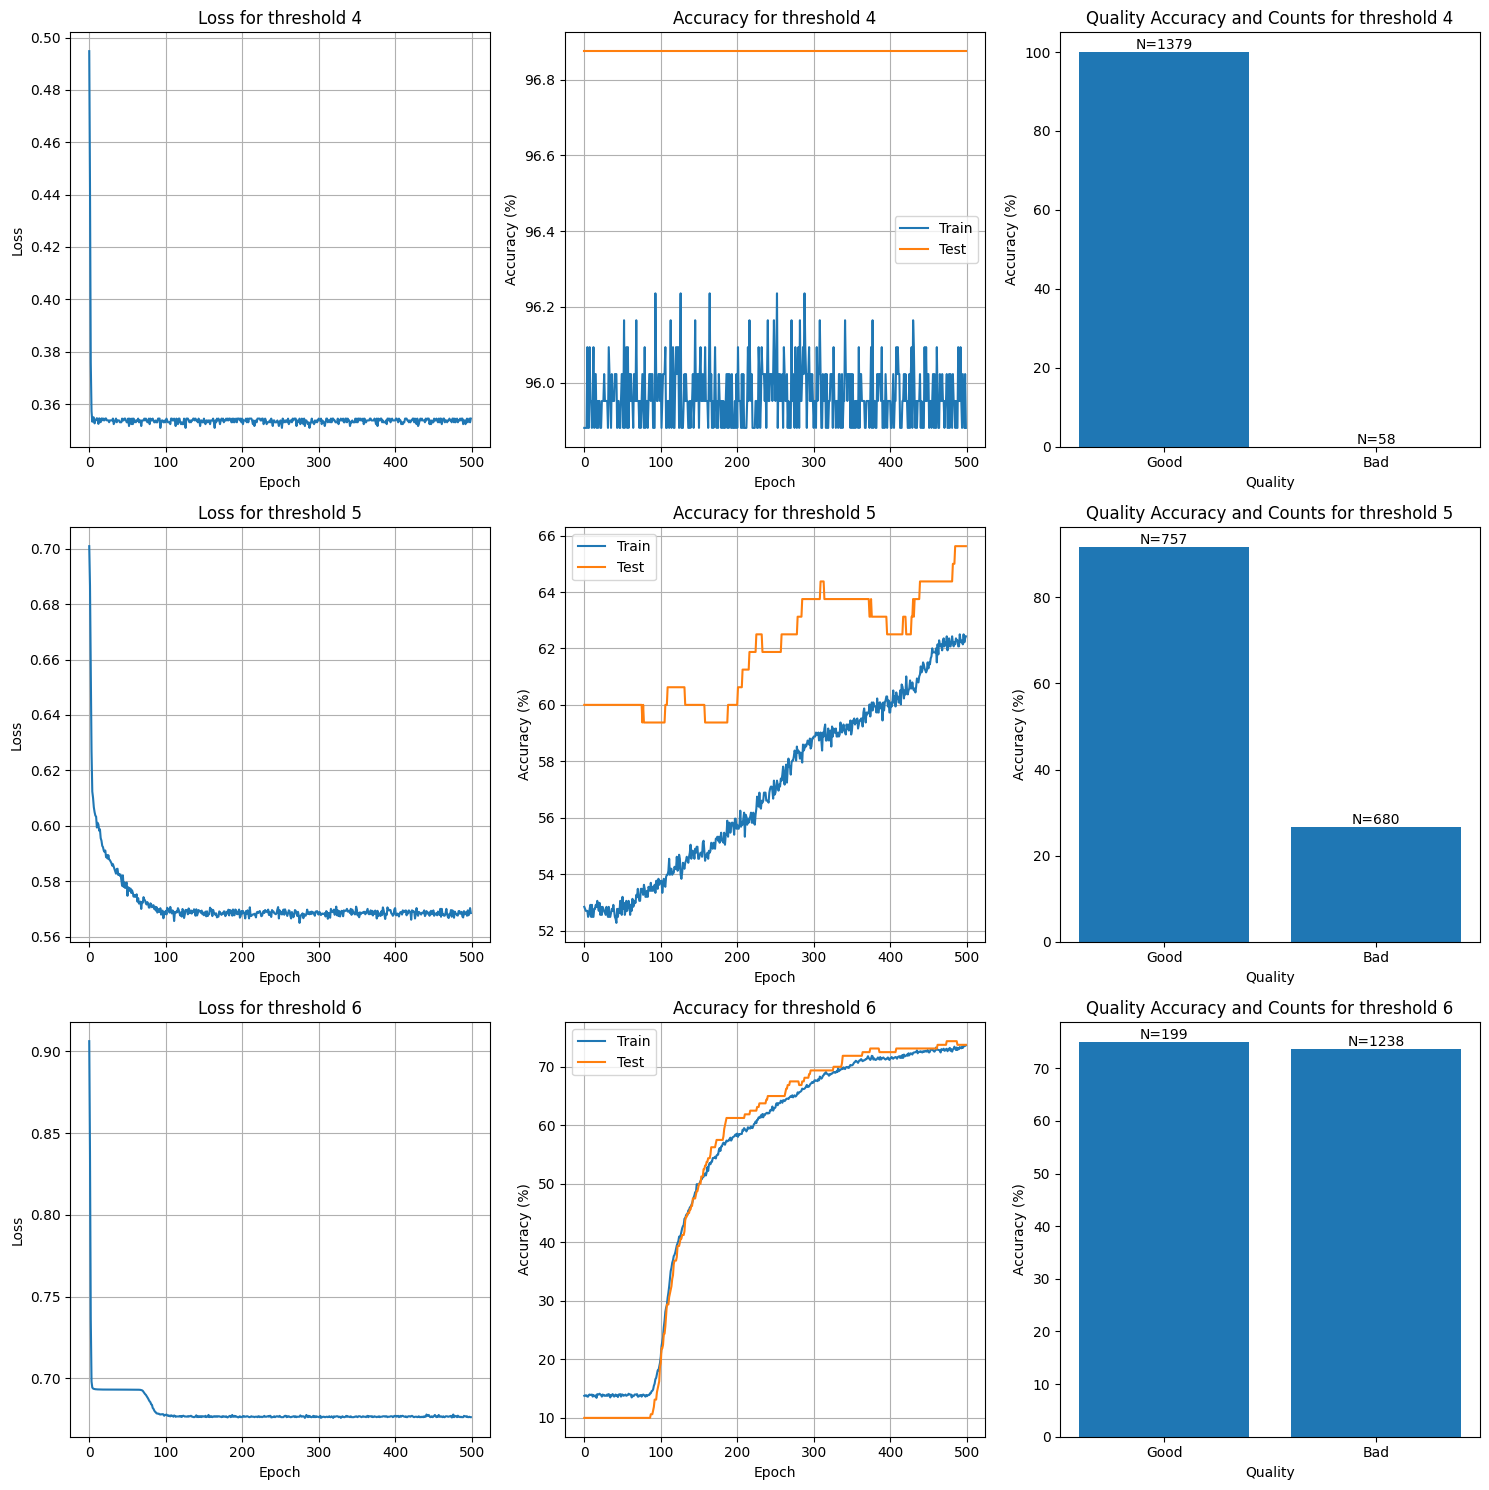

In [185]:
fig, axs = plt.subplots(len(quality_thresholds),3,figsize=(15,15))

for i, thresh in enumerate(quality_thresholds):
  axs[i,0].plot(trainlosses[i,:])
  axs[i,0].set_title(f'Loss for threshold {thresh}')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('Loss')
  # axs[i,0].set_yscale('log')
  axs[i,0].grid(True)

  axs[i,1].plot(trainAccs[i,:])
  axs[i,1].plot(testAccs[i,:])
  axs[i,1].set_title(f'Accuracy for threshold {thresh}')
  axs[i,1].set_xlabel('Epoch')
  axs[i,1].set_ylabel('Accuracy (%)')
  axs[i,1].legend(['Train','Test'])
  axs[i,1].grid(True)

  bars = axs[i,2].bar(['Good','Bad'],[good_quality_accs_test[i],bad_quality_accs_test[i]])
  axs[i,2].set_title(f'Quality Accuracy and Counts for threshold {thresh}')
  axs[i,2].set_xlabel('Quality')
  axs[i,2].set_ylabel('Accuracy (%)') # Changed ylabel to Accuracy (%)
  axs[i,2].bar_label(bars, labels=[f'N={good_quality_counts_train[i]}', f'N={bad_quality_counts_train[i]}'], fmt='%s')


plt.tight_layout()
plt.show();